In [1]:
import os
import sys
sys.path.append('../../')

import json
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from src.utils import get_tweet_filepaths, read_users

In [2]:
main_dir = '../..'
config_path = os.path.join(main_dir, 'config/config.json')

#load config file
assert os.path.exists(config_path)
with open(config_path) as file:
    config = json.load(file)

    graph_path = os.path.join(main_dir, config['graphs_dir'])
    
plot_path = os.path.join(main_dir, config['plots_dir'])
results_path = os.path.join(main_dir, config['results_dir'])

In [3]:
all_user_dict = read_users(main_dir, config)

Reading user information files: ['users_2.json', 'users_1.json', 'users_0.json']


In [4]:
#load graph
G = nx.read_graphml(os.path.join(graph_path, f"interaction_graph.graphml")) 

Number of active people: 29434/40959
0-11510


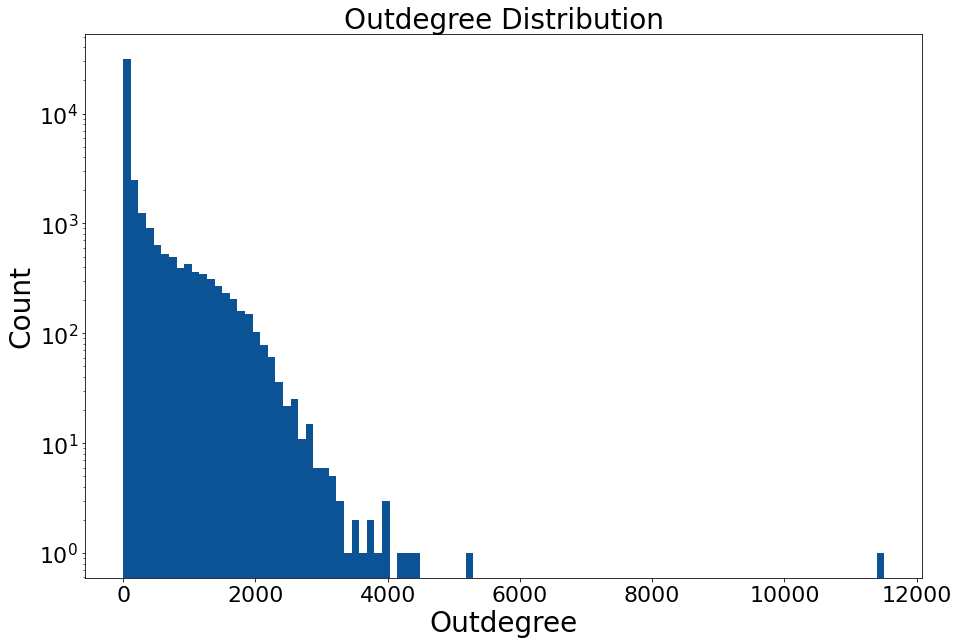

Number of annotated people: 9038/40959
0-158212


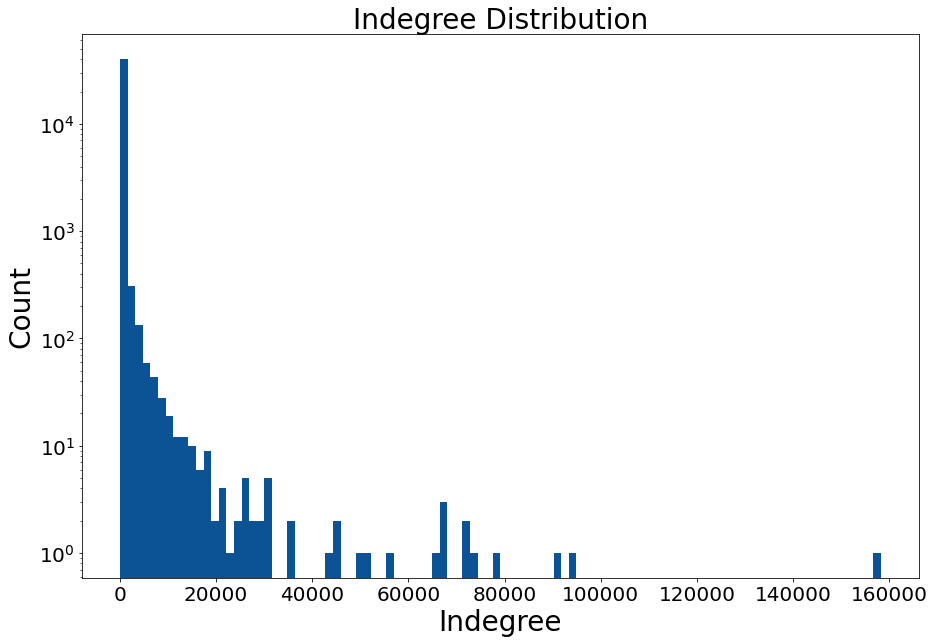

In [5]:
#Determine outdegree distribution
outdegrees = [val for (node, val) in G.out_degree()]
count_0 = 0 
for d in outdegrees:
    if d != 0:
        count_0 += 1
print(f'Number of active people: {count_0}/{len(outdegrees)}')

#plot distribution on a log scale
plt.figure(figsize=(15,10))
minDeg = min(outdegrees)
maxDeg = max(outdegrees)

print(f'{minDeg}-{maxDeg}')
plt.yscale('log')
plt.hist(outdegrees, bins=100, color='#0b5394')
plt.title("Outdegree Distribution", fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel("Count", fontsize=28)
plt.xlabel("Outdegree", fontsize=28)
plt.show()

#Determine indegree distribution
indegrees = [val for (node, val) in G.in_degree()]
count_0 = 0 
for d in indegrees:
    if d == 0:
        count_0 += 1
print(f'Number of annotated people: {count_0}/{len(indegrees)}')


#plot distribution on a log scale
plt.figure(figsize=(15,10))
plt.title("Indegree", fontsize=18)
minDeg = min(indegrees)
maxDeg = max(indegrees)
print(f'{minDeg}-{maxDeg}')

plt.yscale('log')
plt.hist(indegrees, bins=100, color='#0b5394')
plt.title("Indegree Distribution", fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Count", fontsize=28)
plt.xlabel("Indegree", fontsize=28)
plt.show()

## Compare Interaction and Follower Information

In [6]:
print()
print(np.percentile(np.asarray(outdegrees), 98, axis=0))


1653.0


In [7]:
high_indegree_lower_limit = np.percentile(np.asarray(indegrees), 98, axis=0)
high_outdegree_lower_limit = np.percentile(np.asarray(outdegrees), 98, axis=0)
print(f"Frequently annotated (98% percentile of indegree): {high_indegree_lower_limit} ")
print(f"Frequently annotating (98% percentile of indegree): {high_outdegree_lower_limit} ")

Frequently annotated (98% percentile of indegree): 1294.0 
Frequently annotating (98% percentile of indegree): 1653.0 


In [8]:
#Get frequently annotated nodes
high_indeg = []
for (node, val) in G.in_degree():
    if val > high_indegree_lower_limit:
        high_indeg.append((node,val))

#Get frequently annotating nodes
high_outdeg = []
for (node, val) in G.out_degree():
    if val > high_outdegree_lower_limit:
        high_outdeg.append((node,val))

In [10]:
most_annotating = pd.DataFrame()

most_annotating['screen_name'] = [all_user_dict[str(node)]['screen_name'] for (node, val) in  high_outdeg]
most_annotating['id']= [node for (node, val) in  high_outdeg]
most_annotating['indegree']=  [G.in_degree(node) for (node, val) in  high_outdeg]
most_annotating['outdegree']= [val for (node, val) in  high_outdeg]
most_annotating.to_csv(os.path.join(results_path,"most_annotating.csv"))

In [11]:
most_annotated = pd.DataFrame()

most_annotated['screen_name'] = [all_user_dict[str(node)]['screen_name'] for (node, val) in  high_indeg]
most_annotated['id']=[node for (node, val) in  high_indeg]
most_annotated['indegree']=[val for (node, val) in  high_indeg]
most_annotated['outdegree']= [G.out_degree(node) for (node, val) in  high_indeg]

most_annotated = most_annotated.sort_values(by=['indegree'], ascending=False)

In [12]:
most_annotated.to_csv(os.path.join(results_path,"most_popular_annotated.csv"))

In [31]:
print('For Information Sources Plot')
print(f'High Sources: {most_annotated["indegree"].sum()}')
print(f'Others: {G.number_of_edges() - most_annotated["indegree"].sum()}')

print('\nFor Information Spreaders Plot')
print(f'High Spreaders: {most_annotating["outdegree"].sum()}')
print(f'Others: {G.number_of_edges() - most_annotating["outdegree"].sum()}')

For Information Sources Plot
High Sources: 5033809
Others: 2117093

For Information Spreaders Plot
High Spreaders: 1690231
Others: 5460671


In [14]:
annotations_in_percentage = round(most_annotated['indegree'].sum()/G.number_of_edges()*100, 1)
print(f'Share of annotations going to most annotated accounts: {annotations_in_percentage}%')
annotations_out_percentage = round(most_annotating['outdegree'].sum()/G.number_of_edges()*100, 1)
print(f'Share of annotations coming from most annotating accounts: {annotations_out_percentage}%')

Share of annotations going to most annotated accounts: 70.4%
Share of annotations coming from most annotating accounts: 23.6%


In [32]:
#overlap of most annotating and most annotated
list1 = most_annotated['id'].tolist()
list2 = most_annotating['id'].tolist()

joined = list1 + list2
unique = list(set(joined))
overlap = len(joined) - len(unique)

print(f"Overlap: {round(overlap / len(unique),1)*100}%")

print("For Interactiveness Plot")

print(f"Non interactive nodes: {G.number_of_nodes() - len(unique)}")
print(f"Information Spreaders: {len(list1) - overlap}")
print(f"Information Sources: {len(list2) - overlap}")
print(f"Both: {overlap}")

Overlap: 10.0%
For Interactiveness Plot
Non interactive nodes: 39470
Information Spreaders: 670
Information Sources: 671
Both: 148


some pie charts with google Docs: https://docs.google.com/spreadsheets/d/1rapAUEc_HHvb1SGCDIucSXiYPB7cnQ03cjoltY_Iunw/edit?usp=sharing